# An Application of Gaussian Mixture Regression for the Correction of Low Cost $PM_{2.5}$ Monitoring Data in Accra, Ghana
## Daily Averaged Data Analysis
*Celeste McFarlane, Garima Raheja, Carl Malings, Emmanuel K. Appoh, Alison Felix Hughes, Daniel Westervelt*

**Note: To maintain results, the random state must remain the same**

In [1]:
# import required packages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mpc
from sklearn.mixture import GaussianMixture
import pandas as pd
import math
import seaborn as sns; sns.set()
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from gmr import GMM #https://alexanderfabisch.github.io/gmr/gmm.html#gmr.gmm.GMM.predict

from IPython.display import clear_output

%load_ext autoreload
%autoreload 
%matplotlib inline

In [3]:
# import data
# INSERT PATH TO FILE HERE
path = "C:/Users/cmcfa/OneDrive/Desktop/2020 Research/Accra/Full Time Series Scripts/dailyPA_embassy.csv"
data = pd.read_csv(path, header = 0, index_col = 0)

# subset to columns of interest
model_data = data[["purpleair_pm2.5", "avg_temp", "RH", "embassy_pm2.5"]]

In [4]:
# define functions for model evaluation
def n_bias(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    
    true_ = true.reshape(true.shape[0])
    return np.sum(np.subtract(estimated_, true_))/estimated_.shape[0]

def cvMAE(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    true_ = true.reshape(true.shape[0])
    return np.sum(abs(np.subtract(estimated_, true_) - n_bias(estimated_, true)))/np.sum(true_)

def mnbias(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    true_ = true.reshape(true.shape[0])
    return np.sum(np.subtract(estimated_, true_))/np.sum(true_)

def nmae(estimated, true):
    estimated_ = estimated.reshape(estimated.shape[0])
    true_ = true.reshape(true.shape[0])
    return np.sum(np.abs(np.subtract(estimated_, true_)))/np.sum(true_)

In [5]:
# print summary statistics of raw data
print('R2: ', r2_score(model_data[['purpleair_pm2.5']].to_numpy(), model_data[["embassy_pm2.5"]].to_numpy()))
print('MAE: ', mean_absolute_error(model_data[['purpleair_pm2.5']].to_numpy(), model_data[["embassy_pm2.5"]].to_numpy()))
print('Bias: ', n_bias(model_data[['purpleair_pm2.5']].to_numpy(), model_data[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(model_data[['purpleair_pm2.5']].to_numpy(), model_data[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(model_data[['purpleair_pm2.5']].to_numpy(), model_data[["embassy_pm2.5"]].to_numpy()))

R2:  0.5287246856932124
MAE:  6.222034646276251
Bias:  3.4138994135424716
cvMAE:  0.23506715429378475
MNB:  0.13611912359364917


## Build Model With 80:20 Training:Testing Data Split

### Model Selection via Bayesian Information Criterion

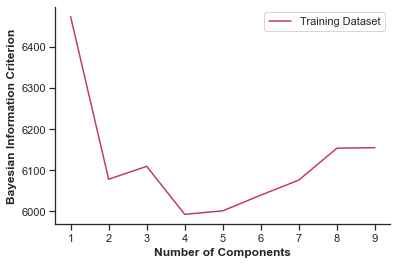

In [7]:
# generate training and testing data splits
train_, test_ = train_test_split(model_data, test_size = 0.2, random_state = 13)

# select models with lowest BIC/AIC
n_components = np.arange(1, 10)
models_train = [GaussianMixture(n, covariance_type = 'full', random_state = 2).fit(train_) for n in n_components]

sns.set_style("ticks", {"xtick.major.size": 7, "ytick.major.size": 7})

plt.plot(n_components, [m.bic(train_) for m in models_train], color = "#C33969", label = 'Training Dataset')
plt.legend(loc = 'upper right')
plt.xlabel('Number of Components', fontweight = 'bold')
plt.ylabel('Bayesian Information Criterion', fontweight = 'bold')

sns.despine()
plt.show()

In [8]:
# build GMM with 4 components as suggested by BIC
gmm = GMM(n_components = 4, random_state = 11)
gmm.from_samples(train_.to_numpy())

#regress test values
Y = gmm.predict(np.array([0,1,2]), test_[["purpleair_pm2.5", "avg_temp", "RH"]].to_numpy())

print('R2: ', r2_score(Y, test_[["embassy_pm2.5"]].to_numpy()))
print('MAE: ', mean_absolute_error(Y, test_[["embassy_pm2.5"]].to_numpy()))
print('Bias: ', n_bias(Y, test_[["embassy_pm2.5"]].to_numpy()))
print('Bias Corrected Mean Normalized Absolute Error: ', cvMAE(Y, test_[["embassy_pm2.5"]].to_numpy()))
print('Mean Normalized Bias: ', mnbias(Y, test_[["embassy_pm2.5"]].to_numpy()))

R2:  0.8758128410473862
MAE:  2.2011462401501536
Bias:  0.4279542464055657
Bias Corrected Mean Normalized Absolute Error:  0.0918754873824311
Mean Normalized Bias:  0.018488167044852764


### Cross Validation

We will now perform a 10 fold cross validation within the training data. We will find the minimum of the BIC for each fold, build a GMM, and then perform a regression

In [10]:
#create 10 fold cross validation object
kf = KFold(n_splits = 10, random_state = 8, shuffle = True)

n_components = np.arange(1, 11) #Find BIC for models with one to ten components

#create array to keep metrics of cross validation
CVs = []

for train_index, test_index in kf.split(train_): 
    #split into training and test data according to kfold iteration
    train, test = train_.to_numpy()[train_index], train_.to_numpy()[test_index]
    
    #find BIC of each split
    models = [GaussianMixture(i, covariance_type = 'full', random_state = 2).fit(train) for i in n_components]
    BIC = [m.bic(train) for m in models]
    n = np.argmin(BIC) + 1 # find the number of components associated with the minimum BIC. We add 1 bc indices begin at 0 in python
    
    #GMR
    gmm_ = GMM(n_components = n, random_state = 11) # build GMM w n components suggested by BIC
    gmm_.from_samples(train)
    Y_ = gmm_.predict(np.array([0,1,2]), test[:, [0,1,2]]) # regress test values
                     
    r2 = r2_score(Y_, test[:, [3]])
    mae = mean_absolute_error(Y_, test[:, [3]])
    bias_gmr = n_bias(Y_, test[:,3])
    cvMAE_gmr = cvMAE(Y_, test[:,3])
    mnbias_gmr = mnbias(Y_, test[:,3])
    
    #MLR
    regr = linear_model.LinearRegression() # generate regression object
    regr.fit(train[:,[0,1,2]], train[:,[3]])
    mlr_pred = regr.predict(test[:,[0,1,2]]) # regress test values
    
    mlr_r2 = r2_score(test[:,3], mlr_pred)
    mlr_mae = mean_absolute_error(test[:,3], mlr_pred)
    bias_mlr = n_bias(mlr_pred, test[:,3])
    cvMAE_mlr = cvMAE(mlr_pred, test[:,3])
    mnbias_mlr = mnbias(mlr_pred, test[:,3])
        
    #Random Forest
    RF_regr = RandomForestRegressor(max_features = 1, random_state = 0) # generate RF pbject
    RF_regr.fit(train[:,[0,1,2]], train[:,[3]])
    RF_pred = RF_regr.predict(test[:,[0,1,2]]) # regress test values
    
    RF_r2 = r2_score(test[:,3], RF_pred)
    RF_mae = mean_absolute_error(test[:,3], RF_pred)
    bias_RF = n_bias(RF_pred, test[:,3])
    cvMAE_RF = cvMAE(RF_pred, test[:,3])
    mnbias_RF = mnbias(RF_pred, test[:,3])
                   
    row = np.array([r2, mlr_r2, RF_r2, 
                    mae, mlr_mae, RF_mae,
                    cvMAE_gmr, cvMAE_mlr, cvMAE_RF,
                    bias_gmr, bias_mlr, bias_RF,
                    mnbias_gmr, mnbias_mlr, mnbias_RF])
    CVs.append(row) #add row to array

CVs = pd.DataFrame(CVs, columns = ['GMR R2', 'MLR R2', 'RF R2',
                                   'GMR MAE', 'MLR MAE', 'RF MAE',
                                  'GMR cvMAE', 'MLR cvMAE', 'RF cvMAE',
                                  'GMR Bias', 'MLR Bias', 'RF Bias',
                                  'GMR mnBias', 'MLR mnBias', 'RF mnBias'])

In [11]:
CVs

,GMR R2,MLR R2,RF R2,GMR MAE,MLR MAE,RF MAE,GMR cvMAE,MLR cvMAE,RF cvMAE,GMR Bias,MLR Bias,RF Bias,GMR mnBias,MLR mnBias,RF mnBias
0,0.300876,0.710961,0.694068,2.919638,3.294567,2.949323,0.123712,0.131397,0.122438,-0.066110,0.807167,0.191575,-0.002783,0.033982,0.008065
1,0.707679,0.600249,0.716230,2.847039,3.551379,2.781951,0.123678,0.153189,0.116898,0.099399,0.399796,-0.459731,0.004286,0.017239,-0.019823
2,0.706179,0.516058,0.642423,3.349655,3.638733,3.107754,0.138577,0.157571,0.126590,1.778847,1.559348,1.839330,0.076013,0.066633,0.078597
3,0.490148,0.680362,-0.192364,3.258547,3.652745,5.124222,0.133336,0.142797,0.204740,0.119969,1.103241,2.279794,0.004896,0.045025,0.093042
4,0.787533,0.636066,0.534386,5.694345,6.445713,7.204269,0.183770,0.235696,0.276798,-0.294102,-3.889959,-4.146983,-0.009413,-0.124504,-0.132730
5,0.732672,0.685264,0.825520,3.140593,3.360757,2.276430,0.132901,0.140748,0.096115,0.753345,-0.244027,-0.194174,0.031425,-0.010179,-0.008100
6,0.755050,0.586865,0.716703,2.748297,3.288117,2.808483,0.114353,0.133670,0.114375,-0.340905,0.251242,0.231513,-0.014049,0.010354,0.009541
7,0.356347,0.579470,0.641365,6.717631,6.675565,6.397437,0.222464,0.225322,0.225254,-2.391117,-3.554907,-3.258463,-0.075233,-0.111851,-0.102523
8,0.677686,0.763006,0.593317,2.505720,2.931928,3.233971,0.110954,0.121707,0.130613,-0.311618,0.900417,1.092959,-0.013291,0.038406,0.046618
9,0.680258,0.461762,0.789207,4.476753,5.257552,3.022109,0.183854,0.182376,0.109800,2.625306,2.223181,0.828647,0.100544,0.085143,0.031735


### Generate Confidence Intervals

In [26]:
# define covariance function
def total_cov(means, covs, weights, n):
    sum_term = []
    output_mean = np.sum(weights*means.T)
    for i in np.arange(n):
        term = weights[i]*(covs[i] + means[i]*means[i].T)
        sum_term.append(term)
    summation = np.sum(sum_term) #yes, I know this is a dumb way to do it, but its nice to be able to print individual terms
    cov = summation - output_mean*output_mean.T
    return cov

In [29]:
CIs = []
means = []

for i in range(np.shape(model_data)[0]):
    # generate conditional distribution of reference value given a single observations PA, RH and T values
    # condition function is similar to predict function expcept it full describes the conditional distribution. The predict function only returns the distribution mean
    cond = gmm.condition(np.array([0,1,2]), model_data[["purpleair_pm2.5", "avg_temp", "RH"]].to_numpy()[i]) 
    # find covariance of distribution. Note we only have one one variable so the Cov(ref, ref) = var(ref)
    cov = total_cov(cond.means, cond.covariances, cond.priors, 4) 
    s = math.sqrt(cov) # find standard error
    z = 1.96
    ci = z*s
    CIs.append(ci)

### Missing Input Analysis

**Missing RH Values**

In [14]:
# condition gmm only over temperature and PA PM2.5
Y_noRH = gmm.predict(np.array([0,1]), test_[["purpleair_pm2.5", "avg_temp"]].to_numpy())

# make sure to evaluate metrics of PM2.5 estimates and not RH estimates (index 0)
print('R2: ', r2_score(Y_noRH[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('MAE: ', mean_absolute_error(Y_noRH[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('Bias: ', n_bias(Y_noRH[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(Y_noRH[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(Y_noRH[:,1], test_[["embassy_pm2.5"]].to_numpy()))

R2:  0.8451764648076882
MAE:  2.4620754883840736
Bias:  0.8486879587710159
cvMAE:  0.10358505706685912
MNB:  0.036664397847436796


**Missing Temperature Values**

In [15]:
# condition gmm only over RH and PA PM2.5
Y_notemp = gmm.predict(np.array([0,2]), test_[["purpleair_pm2.5", "RH"]].to_numpy())

# make sure to evaluate metrics of PM2.5 estimates and not temp estimates
print('R2: ', r2_score(Y_notemp[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('MAE: ', mean_absolute_error(Y_notemp[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('Bias: ', n_bias(Y_notemp[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(Y_notemp[:,1], test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(Y_notemp[:,1], test_[["embassy_pm2.5"]].to_numpy()))

R2:  0.8275563114817316
MAE:  2.4282069816204563
Bias:  0.34812771264073555
cvMAE:  0.10371548260895914
MNB:  0.015039559388189575


**Missing RH and Temperature Values**

In [16]:
# condition gmm only overPA PM2.5
Y_justPA = gmm.predict(np.array([0]), test_[["purpleair_pm2.5"]].to_numpy())

# make sure to evaluate metrics of PM2.5 estimates and not RH or temp estimates
print('R2: ', r2_score(Y_justPA[:,2], test_[["embassy_pm2.5"]].to_numpy()))
print('MAE: ', mean_absolute_error(Y_justPA[:,2], test_[["embassy_pm2.5"]].to_numpy()))
print('Bias: ', n_bias(Y_justPA[:,2], test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(Y_justPA[:,2], test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(Y_justPA[:,2], test_[["embassy_pm2.5"]].to_numpy()))

R2:  0.7412943501867837
MAE:  3.164754807267876
Bias:  0.2897038053188351
cvMAE:  0.13386072538075458
MNB:  0.012515572380109629


## GMR Figures

In [19]:
# get array of resposnsibilities based on ORGINAL GMM and not GMR. 
# Use the condition function if you want responsibilities based off the GMR
probs = gmm.to_responsibilities(model_data)
labels = np.argmax(probs, axis = 1)

# create size object to visualize responsibilities more easily
size = 50 * probs.max(1) ** 3
legend_values = labels + 1

In [17]:
# get array of biases to plot
bias = model_data[["purpleair_pm2.5"]].to_numpy() - model_data[["embassy_pm2.5"]].to_numpy() 

# regress entire data set
Y2 = gmm.predict(np.array([0,1,2]), model_data[["purpleair_pm2.5", "avg_temp", "RH"]].to_numpy())
modelbias = Y2 - model_data[["embassy_pm2.5"]].to_numpy()

# set color map
colors = mpc.ListedColormap(['#C33969','#078681','#5b0fff', '#E17400'])

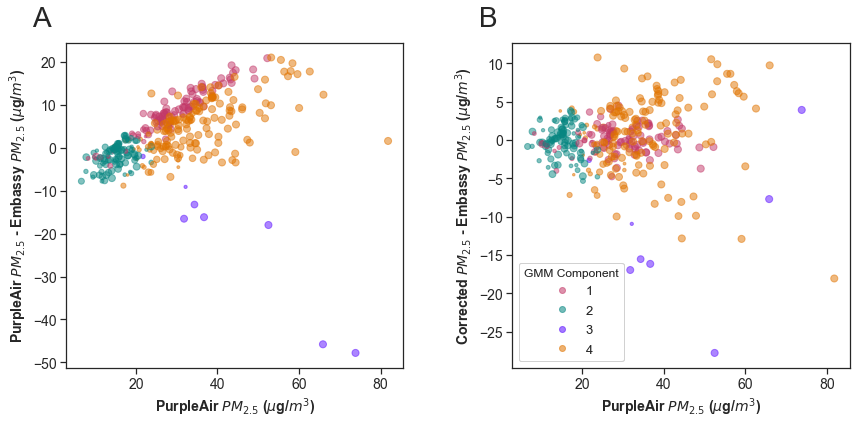

In [20]:
sns.set_style("ticks", {"xtick.major.size": 7, "ytick.major.size": 7})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(model_data[['purpleair_pm2.5']], bias, c = legend_values, cmap = colors, s = size, alpha = 0.5)
ax1.tick_params(axis ='x', labelsize = 14)
ax1.tick_params(axis ='y', labelsize = 14)
ax1.set_xlabel('PurpleAir $PM_{2.5}$ ($\mu$g/$m^3$)', fontweight = 'bold', fontsize = 14)
ax1.set_ylabel('PurpleAir $PM_{2.5}$ - Embassy $PM_{2.5}$ ($\mu$g/$m^3$)', fontweight = 'bold', fontsize = 14)
ax1.text(-0.1, 1.05, "A", transform = ax1.transAxes, size = 28)

scatterb = ax2.scatter(model_data[['purpleair_pm2.5']], modelbias, c = legend_values, cmap = colors, s = size, alpha = 0.5)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_xlabel('PurpleAir $PM_{2.5}$ ($\mu$g/$m^3$)', fontweight = 'bold', fontsize = 14)
ax2.set_ylabel('Corrected $PM_{2.5}$ - Embassy $PM_{2.5}$ ($\mu$g/$m^3$)', fontweight = 'bold', fontsize = 14)
ax2.text(-0.1, 1.05, "B", transform = ax2.transAxes, size = 28)
legend2 = ax2.legend(*scatterb.legend_elements(), loc = 'best', title = "GMM Component", fontsize = 13)
ax2.add_artist(legend2)
plt.setp(legend2.get_title(), fontsize = 12)

fig.tight_layout(w_pad = 5)

plt.show();

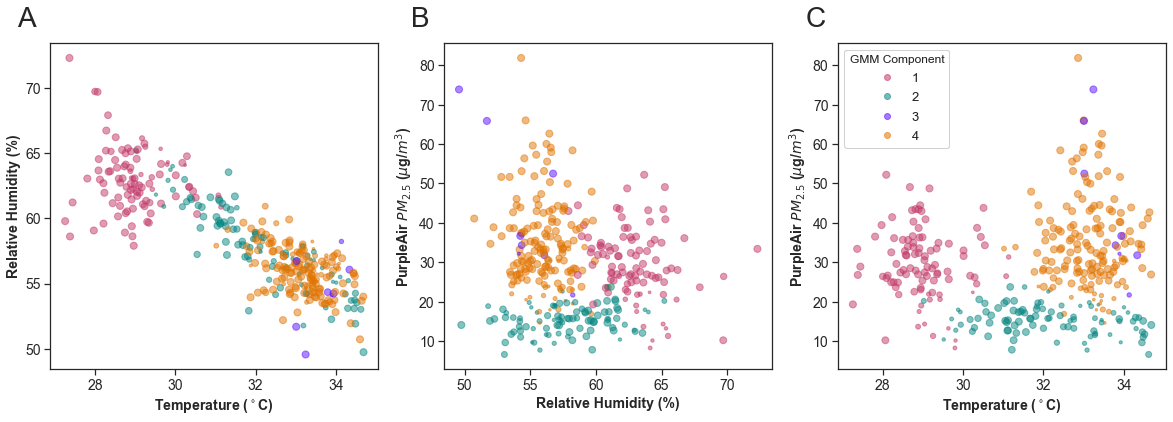

In [22]:
sns.set_style("ticks", {"xtick.major.size": 7, "ytick.major.size": 7})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.scatter(model_data[['avg_temp']], model_data[['RH']], c = legend_values, cmap = colors, s = size, alpha = 0.5)
ax1.tick_params(axis='x', labelsize = 14)
ax1.tick_params(axis='y', labelsize = 14)
ax1.set_xlabel('Temperature ($^\circ$C)', fontweight = 'bold', fontsize = 14)
ax1.set_ylabel('Relative Humidity (%)', fontweight = 'bold', fontsize = 14)
ax1.text(-0.1, 1.05, "A", transform = ax1.transAxes, size = 28)

ax2.scatter(model_data[['RH']], model_data[['purpleair_pm2.5']], c = legend_values, cmap = colors, s = size, alpha = 0.5)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylabel('PurpleAir $PM_{2.5}$ ($\mu$g/$m^3$)', fontweight = 'bold', fontsize = 14)
ax2.set_xlabel('Relative Humidity (%)', fontweight = 'bold', fontsize = 14)
ax2.text(-0.1, 1.05, "B", transform = ax2.transAxes, size = 28)

scatter3  = ax3.scatter(model_data[['avg_temp']], model_data[['purpleair_pm2.5']], c = legend_values, cmap = colors, s = size, alpha = 0.5)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax3.set_ylabel('PurpleAir $PM_{2.5}$ ($\mu$g/$m^3$)', fontweight = 'bold', fontsize = 14)
ax3.set_xlabel('Temperature ($^\circ$C)', fontweight = 'bold', fontsize = 14)
ax3.text(-0.1, 1.05, "C", transform = ax3.transAxes, size = 28)
legend3 = ax3.legend(*scatter3.legend_elements(), loc = 'best', title = "GMM Component", fontsize = 13)
ax3.add_artist(legend3)
plt.setp(legend3.get_title(), fontsize = 12)

plt.show();

## Model Comparison

### Multiple Linear Regression

In [23]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training set
regr.fit(train_[["purpleair_pm2.5", "avg_temp", "RH"]], train_[["embassy_pm2.5"]])

# regress the testing data
mlr_pred = regr.predict(test_[["purpleair_pm2.5", "avg_temp", "RH"]]).reshape(test_.shape[0])

print('R2: ', r2_score(test_[["embassy_pm2.5"]], mlr_pred))
print('MAE: ', mean_absolute_error(test_[["embassy_pm2.5"]], mlr_pred))
print('Bias: ', n_bias(mlr_pred, test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(mlr_pred, test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(mlr_pred, test_[["embassy_pm2.5"]].to_numpy()))

R2:  0.8118037828533213
MAE:  2.830186408198583
Bias:  0.7052206613625073
cvMAE:  0.12118679693094586
MNB:  0.030466428362987758


#### Build MLR models with subsets of data

In [25]:
# train the model without RH
regr_noRH = linear_model.LinearRegression()
regr_noRH.fit(train_[["purpleair_pm2.5", "avg_temp"]], train_[["embassy_pm2.5"]])

mlr_noRH = regr_noRH.predict(test_[["purpleair_pm2.5", "avg_temp",]])

print('PM2.5c = B1*PAPM2.5 + B2*Temp')
print('R2: ', r2_score(test_[["embassy_pm2.5"]], mlr_noRH))
print('MAE: ', mean_absolute_error(test_[["embassy_pm2.5"]], mlr_noRH))
print('Bias: ', n_bias(mlr_noRH, test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(mlr_noRH, test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(mlr_noRH, test_[["embassy_pm2.5"]].to_numpy()))

# train the model without temp
regr_notemp = linear_model.LinearRegression()
regr_notemp.fit(train_[["purpleair_pm2.5", "RH"]], train_[["embassy_pm2.5"]])

mlr_notemp = regr_notemp.predict(test_[["purpleair_pm2.5", "RH",]])

print('\n', 'PM2.5c = B1*PAPM2.5 + B2*RH')
print('R2: ', r2_score(test_[["embassy_pm2.5"]], mlr_notemp))
print('MAE: ' ,mean_absolute_error(test_[["embassy_pm2.5"]], mlr_notemp))
print('Bias: ', n_bias(mlr_notemp, test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(mlr_notemp, test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(mlr_notemp, test_[["embassy_pm2.5"]].to_numpy()))

# train the model without RH or temp
regr_no = linear_model.LinearRegression()
regr_no.fit(train_[["purpleair_pm2.5"]], train_[["embassy_pm2.5"]])

mlr_no = regr_no.predict(test_[["purpleair_pm2.5"]])

print('\n', 'PM2.5c = B1*PAPM2.5')
print('R2: ', r2_score(test_[["embassy_pm2.5"]], mlr_no))
print('MAE: ', mean_absolute_error(test_[["embassy_pm2.5"]], mlr_no))
print('Bias: ', n_bias(mlr_no, test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ' ,cvMAE(mlr_no, test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(mlr_no, test_[["embassy_pm2.5"]].to_numpy()))

PM2.5c = B1*PAPM2.5 + B2*Temp
R2:  0.8380693956843859
MAE:  2.604960888148927
Bias:  0.6476030074273569
cvMAE:  0.11103901574825539
MNB:  0.027977272525342295

 PM2.5c = B1*PAPM2.5 + B2*RH
R2:  0.7796797371977049
MAE:  3.0397726077120275
Bias:  0.7166495554123089
cvMAE:  0.13086667871875365
MNB:  0.030960171103258202

 PM2.5c = B1*PAPM2.5
R2:  0.7140446282676859
MAE:  3.428285474327511
Bias:  0.44380134764587037
cvMAE:  0.15022598140593862
MNB:  0.019172781947890297


### Random Forest

In [26]:
RF_regr = RandomForestRegressor(max_features = 1, random_state = 0)
RF_regr.fit(train_[["purpleair_pm2.5", "avg_temp", "RH"]], train_[["embassy_pm2.5"]])

RF_pred = RF_regr.predict(test_[["purpleair_pm2.5", "avg_temp", "RH"]])

print('R2: ', r2_score(test_[["embassy_pm2.5"]], RF_pred))
print('MAE: ', mean_absolute_error(test_[["embassy_pm2.5"]], RF_pred))
print('Bias: ', n_bias(RF_pred, test_[["embassy_pm2.5"]].to_numpy()))
print('cvMAE: ', cvMAE(RF_pred, test_[["embassy_pm2.5"]].to_numpy()))
print('MNB: ', mnbias(RF_pred, test_[["embassy_pm2.5"]].to_numpy()))

R2:  0.811988310167433
MAE:  2.724539901171275
Bias:  0.9754181047979088
cvMAE:  0.11275412023816367
MNB:  0.04213930113217567
